In [36]:
import numpy as np
import struct
import os
import tensorflow as tf
import matplotlib.pyplot as plt



''' Helper class '''


class MNIST_GAN():
    def __init__(self, directory=""):
        self._directory = directory

        self._data = self._load_binaries("train-images-idx3-ubyte")
        self._data = np.append(self._data, self._load_binaries("t10k-images-idx3-ubyte"), axis=0)
        self._data = ((self._data / 255) * 2) - 1
        self._data = self._data.reshape([-1, 28, 28, 1])

    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)

        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype='uint8')
                return np.reshape(images, (items_n, height, width))
            else:
                raise ValueError("Not a MNIST file: " + path)

    def get_batch(self, batch_size):
        samples_n = self._data.shape[0]
        if batch_size <= 0:
            batch_size = samples_n

        random_indices = np.random.choice(samples_n, samples_n, replace=False)
        data = self._data[random_indices]

        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off]


mnist_data = MNIST_GAN()

(28, 28)


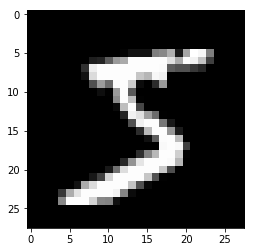

In [35]:
''' Investigate Data '''


pixels = (mnist_data._data[0])
pixels = np.squeeze(pixels)
print(pixels.shape)
plt.imshow(pixels, cmap='gray')
plt.show()

In [37]:
''' Layer functions '''


def feed_forward_layer(x, target_size, normalize=False, activation_function=None):
    print("Forward-Layer:" + str(x.shape))

    fan_in = int(x.shape[-1])

    if activation_function == tf.nn.relu:
        var_init = tf.random_normal_initializer(stddev=2 / fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev=fan_in ** (-1 / 2))
    weights = tf.get_variable("weights", [x.shape[1], target_size], tf.float32, var_init)

    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [target_size], tf.float32, var_init)

    activation = tf.matmul(x, weights) + biases

    if normalize:
        activation = batch_norm(activation, [0])

    return activation_function(activation) if callable(activation_function) else activation


def conv_layer(x, kernel_quantity, kernel_size, stride_size, normalize=False, activation_function=False):
    print("Conv-Layer:" + str(x.shape))
    depth = x.shape[-1]
    fan_in = int(x.shape[1] * x.shape[2])

    if activation_function == tf.nn.relu or activation_function == tf.nn.leaky_relu:
        var_init = tf.random_normal_initializer(stddev=2 / fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev=fan_in ** (-1 / 2))
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, depth, kernel_quantity], tf.float32, var_init)

    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [kernel_quantity], initializer=var_init)

    activation = tf.nn.conv2d(x, kernels, strides=[1, stride_size, stride_size, 1], padding="SAME") + biases

    if normalize:
        activation = batch_norm(activation, [0, 1, 2])

    return activation_function(activation) if callable(activation_function) else activation


def back_conv_layer(x, target_shape, kernel_size, stride_size, normalize=False, activation_function=False):
    pass


def flatten(x):
    size = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, size])


def _pop_batch_norm(x, pop_mean, pop_var, offset, scale):
    return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, 1e-6)


def _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale):
    decay = 0.99

    dependency_1 = tf.assign(pop_mean, pop_mean * decay + mean * (1 - decay))
    dependency_2 = tf.assign(pop_var, pop_var * decay + var * (1 - decay))

    with tf.control_dependencies([dependency_1, dependency_2]):
        return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)


def batch_norm(x, axes):
    depth = x.shape[-1]
    mean, var = tf.nn.moments(x, axes=axes)

    var_init = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [depth], tf.float32, var_init)
    var_init = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [depth], tf.float32, var_init)

    pop_mean = tf.get_variable("pop_mean", [depth], initializer=tf.zeros_initializer(), trainable=False)
    pop_var = tf.get_variable("pop_var", [depth], initializer=tf.ones_initializer(), trainable=False)

    return tf.cond(
        is_training,
        lambda: _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale),
        lambda: _pop_batch_norm(x, pop_mean, pop_var, offset, scale)
    )

In [38]:
''' Hyperparameters '''


amount_real_images = 32
amount_fake_images = 32
amount_generator_maps_l1 = 64
amount_generator_maps_l2 = 32
amount_generator_maps_l3 = 16
amount_discrimninator_maps_l1 = 8
amount_discrimninator_maps_l2 = 16
amount_discrimninator_maps_l3 = 32
dimensionality_z = 50
learning_rate = 0.0004
beta1_adam_optmimizer = 0.5
epochs = 2



''' '''

' '